# HANK Model Application 

#### Felipe Alves

### Type examples

Let's take a look on some of the types defined in the project

In [ ]:
"""
Consumption-saving problem with two assets and non-convex adjustment costs

## Fields

#### Parameters
- `γ::Float64`  : parameter on CRRA utility
- `ρ::Float64`  : discount factor
- `ξ::Float64`  : automatic deposit
- `σ::Float64`  : frisch elasticity of labor supply
- `ψ::Float64`  : disutility of labor

#### Prices
- `rᴬ::Float64`     : interest rate on illiquid asset
- `rᴮ::Float64`     : interest rate for savings in liquid asset
- `wedge::Float64`  : interest rate for borrowing in liquid asset
- `w::Float64`      : wage rate

#### Tax
- `τ::Float64`      : tax on income
- `T::Float64`      : Lump-sum transfer

#### Cost Function
- `χ₀::Float64` :
- `χ₁::Float64` :
"""
type TwoAssetsProb
    γ::Float64      # CRRA utility with parameter γ
    ρ::Float64      # discount rate
    σ::Float64
    ψ::Float64
    ξ::Float64      # automatic deposit on illiquid asset

    rᴬ ::Float64    # ret on illiquid asset
    rᴮ::Float64    # ret on liq asset
    wedge::Float64
    w  ::Float64    # wage rate

    τ::Float64
    T::Float64

    χ₀::Float64     # parameters on adjustment cost
    χ₁::Float64
end

In [ ]:
type SolutionExp

    ## Solution
    V::Vector{Vector{Float64}}      # Value function
    g::Vector{Vector{Float64}}      # Density over state space
    c::Array{Float64,3}             # Optimal consumption
    sc::Array{Float64,3}            # Savings without deposit
    d::Array{Float64,3}             # Optimal deposit flow

    ## Matrices to be filled
    A ::Vector{Base.SparseMatrix.SparseMatrixCSC{Float64, Int}}  # used on HJB to compute vⁿ⁺¹
    Au::Vector{Base.SparseMatrix.SparseMatrixCSC{Float64, Int}}  # used for KFE to compute transition dynamics

end

"""
Specification for the Implicit-Explicit Finite Difference method
"""
type FDExp

    ## GRID INFO
    b      ::Vector{Float64}
    Δbgrid ::Vector{Float64}
    ΔTbgrid::Vector{Float64}
    rbdrift::Vector{Float64}
    netbinc::Matrix{Float64}

    a      ::Vector{Float64}
    Δagrid ::Vector{Float64}
    ΔTagrid::Vector{Float64}
    radrift::Vector{Float64}
    netainc::Matrix{Float64}

    ΔTab::Vector{Float64}

    ## LaborSupply decisions
    ℓsupply::Vector{Float64}
    ℓutilgrid::Vector{Float64}

    ## Δ in finite difference scheme
    invΔ::Float64
    invΔᴷ::Float64

    ## Stochastic Information
    z::Vector{Float64}
    λ::Matrix{Float64}
    λdiag::Vector{Float64}
    λoff::Matrix{Float64}

    ## Solution
    sol::SolutionExp

    ## Storage
    btilde ::Vector{Vector{Float64}}                                  # RHS of hjb
    B ::Vector{Base.SparseMatrix.SparseMatrixCSC{Float64, Int}}  # storage matrix

    
end

This is useful for bigger projects

In [ ]:
function Base.show(io::IO, fd::FDExp)
    fd.Δbgrid[2]-fd.Δbgrid[1] == 0 ? (binfo = "uniform ") : (binfo = "non-uniform ")
    fd.Δagrid[2]-fd.Δagrid[1] == 0 ? (ainfo = "uniform ") : (ainfo = "non-uniform ")
    @printf io "\n"
    @printf io "    Explicit-Implicit Finite Difference Method\n"
    @printf io "\n"
    @printf io "    Grids  \n"
    @printf io "   ------- \n"
    @printf io "     %12sb: %3d points in [% .0f, %.0f]\n" binfo length(fd.b) fd.b[1] fd.b[end]
    @printf io "     %12sa: %3d poitns in [% .0f, %.0f]\n" ainfo length(fd.a) fd.a[1] fd.a[end]
end

### Include files

In [70]:
#== INCLUDE files ==#
include("aggregate.jl")
include("twoassets.jl")

include("solveHJB.jl")
include("solveKFE.jl")

solve_fp! (generic function with 2 methods)

Let's create an `TwoAssetProblem` instance

In [71]:
#== Instance of prices ==#
pr = Prices(0.0, 0.04, 0.03, 0.09, 8.0)

#== Instance of TwoAssetProblem ==#
twoap = TwoAssetsProb2(pr; γ = 2.0, ρ = 0.06, ξ = 0.10, χ₀ = 0.08, χ₁= 3.0, τ = 0.0, T = 0.0)

    HOUSEHOLD PROBLEM

    Parameters  
   ------------ 
     γ:      2.000
     ρ:      0.060
     ξ:      0.100

    Prices  
   -------- 
     rᴬ   :    0.040 
     rᴮ   :    0.030 
     wage :    8.000 
     τ    :    0.000 
     T    :    0.000 

    Cost Function  
   --------------- 
     χ₀ + χ₁ * (d/a)² * a



With that I will create the Finite Difference specification

In [79]:
#== Create and FiniteDifference Structure ==#
fde = FDExp(twoap; z = [.8, 1.3], λ = [-1/3 1/3; 1/3 -1/3],
fixedΔa = true, fixedΔb = false, bn = 100, bmin = -2.0, bmax = 40.0, an =70, amax = 70.0, invΔᴷ = 0.05)


    Explicit-Implicit Finite Difference Method

    Grids  
   ------- 
     non-uniform b: 100 points in [-2, 40]
         uniform a:  70 poitns in [ 0, 70]



The solve_hjb function will use information from 
```julia
twoap::TwoAssetProblem
fde::FDExpl
```
and save solution on 
```julia
fde.sol::SolutionExp
```

Why is useful to separate these? Further in the code, when we are doing transitional dynamics, I will maintain grid structure while solution will change for each period. Moreover I will need to save all `SolutionExp` before computing the dynamics. 


In [80]:
#== Solve the HJB equation ==#
solve_hjb!(twoap, fde, fde.sol)

  value function iteration 10, distance 0.1684 
  value function iteration 20, distance 0.0264 
  value function iteration 30, distance 0.0051 
  value function iteration 40, distance 0.0010 
  value function iteration 50, distance 0.0002 
  value function iteration 60, distance 0.0000 
  value function iteration 70, distance 0.0000 
  value function iteration 80, distance 0.0000 
  value function iteration 90, distance 0.0000 
  value function iteration 100, distance 0.0000 
  value function iteration 110, distance 0.0000 
hjb solved : 115 iterations


In [81]:
#== Solve the KF equation ==#
solve_fp!(fde, fde.sol, maxit = 4000, tolFK = 1e-9)

  density iteration 50, distance 0.0016 
   sum 1.0000 --> 1.0000
  density iteration 100, distance 0.0000 
   sum 1.0000 --> 1.0000
  density iteration 150, distance 0.0000 
   sum 1.0000 --> 1.0000
  density iteration 200, distance 0.0000 
   sum 1.0000 --> 1.0000
kfe solved : 240 iterations


Void

## Graphs

In [1]:
using PlotlyJS

INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/MbedTLS.ji for module MbedTLS.
INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/HttpServer.ji for module HttpServer.
INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/HttpParser.ji for module HttpParser.
INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/Blink.ji for module Blink.
INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/Mux.ji for module Mux.
INFO: Recompiling stale cache file /Users/Felipe/.julia/lib/v0.4/WebSockets.ji for module WebSockets.


Plotly javascript loaded.

In [82]:
sol = fde.sol
c = sol.c; d = sol.d; sc = sol.sc
b = fde.b; a = fde.a; z = fde.z;

an = length(a)
bn = length(b)
zn = length(z)

netainc = fde.netainc

# agrid, bgrid = meshgrid(a,b)

#== Consumption 2D ==#
tcons = Any[]
for ai in 1:10:an
    push!(tcons,scatter(;x=fde.b, y=c[:,ai,1], name = "Illiquid level $(round(a[ai],1))") )
end

#== Deposits 2D ==#
tdep = Any[]
for ai in 1:10:an
    push!(tdep,scatter(;x=fde.b, y=d[:,ai,2], name = "Illiquid level $(round(a[ai],1))") )
end


lcon = Layout(;title="Consumption Low state", 
    xaxis_range=-2.0, xaxis_title="Liquid asset",
    yaxis_title="Consumption",
    xaxis_showgrid=true, yaxis_showgrid=true,
    legend_y=0.0, legend_x=1.01)



layout with fields legend, margin, title, xaxis, and yaxis


In [83]:
lcons = Layout(;title="Consumption Low state", 
    xaxis_range=-2.0, xaxis_title="Liquid asset",
    yaxis_title="Consumption",
    xaxis_showgrid=true, yaxis_showgrid=true,
    legend_y=0.0, legend_x=1.01)


plot([tcons...], lcons)

In [84]:
ldep = Layout(;title="Deposit High state", 
    xaxis_range=-2.0, xaxis_title="Liquid asset",
yaxis_title="Deposit flow",
    xaxis_showgrid=true, yaxis_showgrid=true,
    legend_y=0.0, legend_x=1.01)

plot([tdep...], l)

Check SUM   
Sum to 1.00 
Check SUM   
Sum to 1.00 


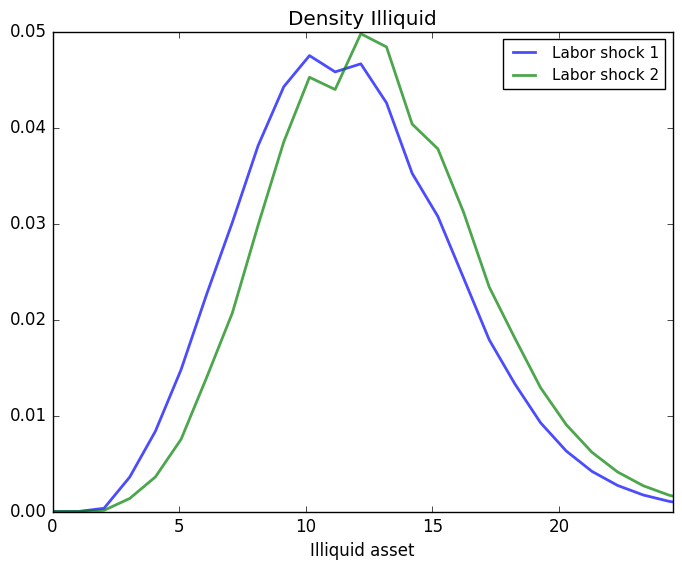

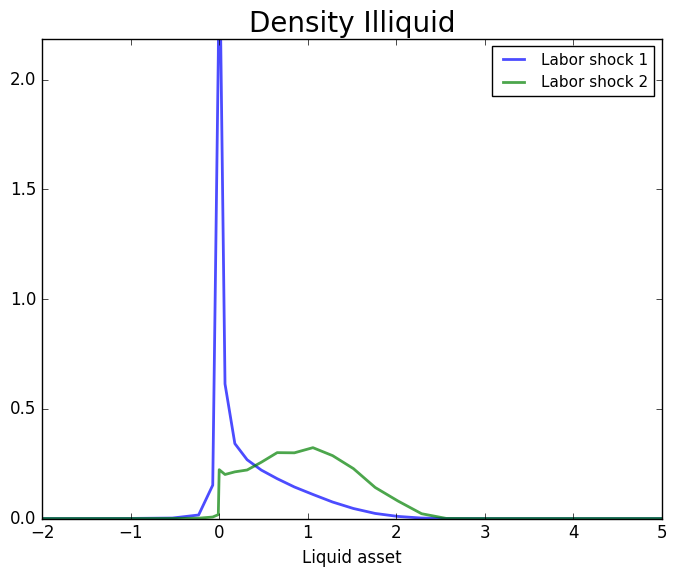

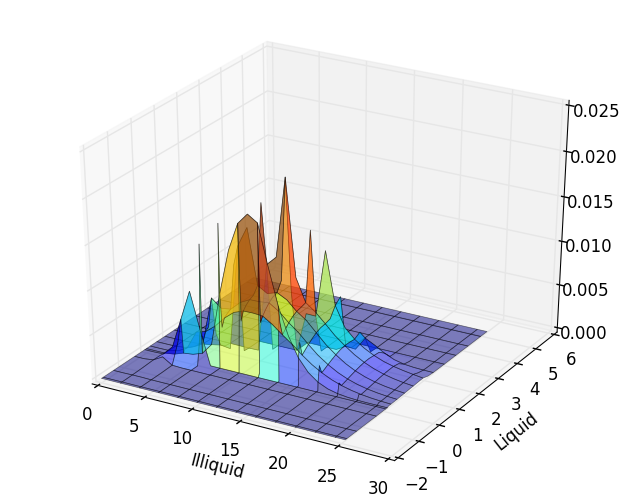

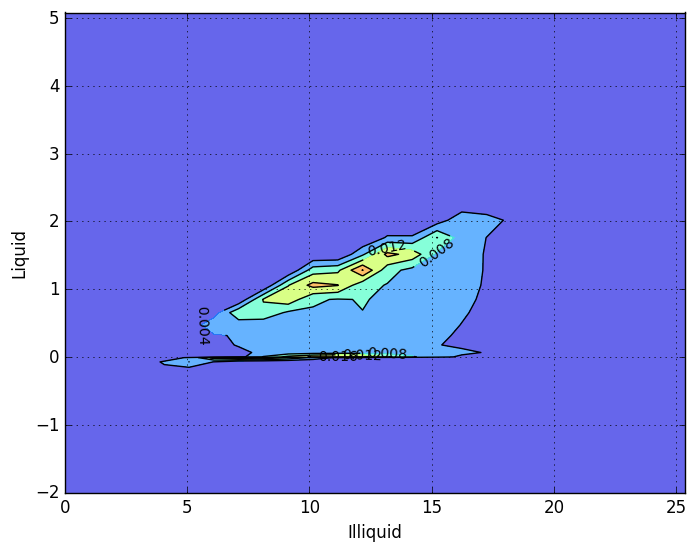

In [87]:
include("main_fig.jl");

#== Policies ==#
# fig_pol(fde)
#== Distributions ==#
fig_dens(fde)